Integrantes:

David Bugoi

Fernando Javier Gómez Márquez

Daniel Hernández Martínez

### **Carga de datos**

Dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import os.path

In [24]:
RANDOM_STATE = 813

In [25]:
def genera_df(ficherocsv, nro_filas=None):
    try:
      from google.colab import drive
      drive.mount('/content/drive')
      df = pd.read_csv(os.path.join('drive/MyDrive/Colab Notebooks/',ficherocsv), nrows=nro_filas)
    except:   # si no es en google colab, se supone que estamos ejecutando el notebook en nuestro servidor local y que el fichero está en el mismo directorio
      df = pd.read_csv(ficherocsv, nrows=nro_filas)
    return df

In [26]:
fdatos = 'heart.csv'
df = genera_df(fdatos)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### **Aplicarción de OneHotEncoder**

In [28]:
categ_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
df_oneHot=pd.get_dummies(df,columns=categ_columns,drop_first=False)
df_oneHot.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


### **Preparación de subconjuntos de datos**

In [29]:
X = df_oneHot.drop(['HeartDisease'], axis=1).values
Y = df_oneHot['HeartDisease'].values

In [39]:
from sklearn.model_selection import train_test_split

X_train_OH, X_test_OH, Y_train_OH, Y_test_OH = train_test_split(X, Y, test_size=0.1, random_state = RANDOM_STATE)
X_train_OH, X_val_OH, Y_train_OH, Y_val_OH = train_test_split(X_train_OH, Y_train_OH, test_size=0.1, random_state = RANDOM_STATE)

X_train_OH.shape, X_test_OH.shape, X_val_OH.shape

((743, 20), (92, 20), (83, 20))

### **Escalado de datos**

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_OH)
X_train_OH= scaler.transform(X_train_OH)

scaler.fit(X_test_OH)
X_test_OH= scaler.transform(X_test_OH)

scaler.fit(X_val_OH)
X_val_OH= scaler.transform(X_val_OH)

### **Identificar función de coste de acuerdo a la versión de sklearn**

In [42]:
import sklearn
if (sklearn.__version__ < "1.1.0"):
  funcion_coste = 'log'
else:
  funcion_coste = 'log_loss'
funcion_coste

'log_loss'

### **Evaluación y comparativa de parámetros**

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

Parámetros y valores a comprobar con el modelo de regresión logística

|Param|Values|
|--|--|
|penalty | None , L1|
|max_iter | 10 , 100 |
|learning_rate | constant , optimal |
|alpha (learning_rate=optimal) | 0.00001 ,	0.0001 ,	0.001 ,	0.01 ,	0.1 ,	1	, 10 |
|eta0 (learning_rate=constant) | 0.001 ,	0.01	, 0.1	, 1	, 10 |





In [44]:
penalties = [None,'l1']
iterations = [10,100]
learning_rates = ['constant','optimal']
alphas = [0.00001 ,	0.0001 ,	0.001 ,	0.01 ,	0.1 ,	1	, 10]
etas = [0.001 ,	0.01	, 0.1	, 1	, 10]

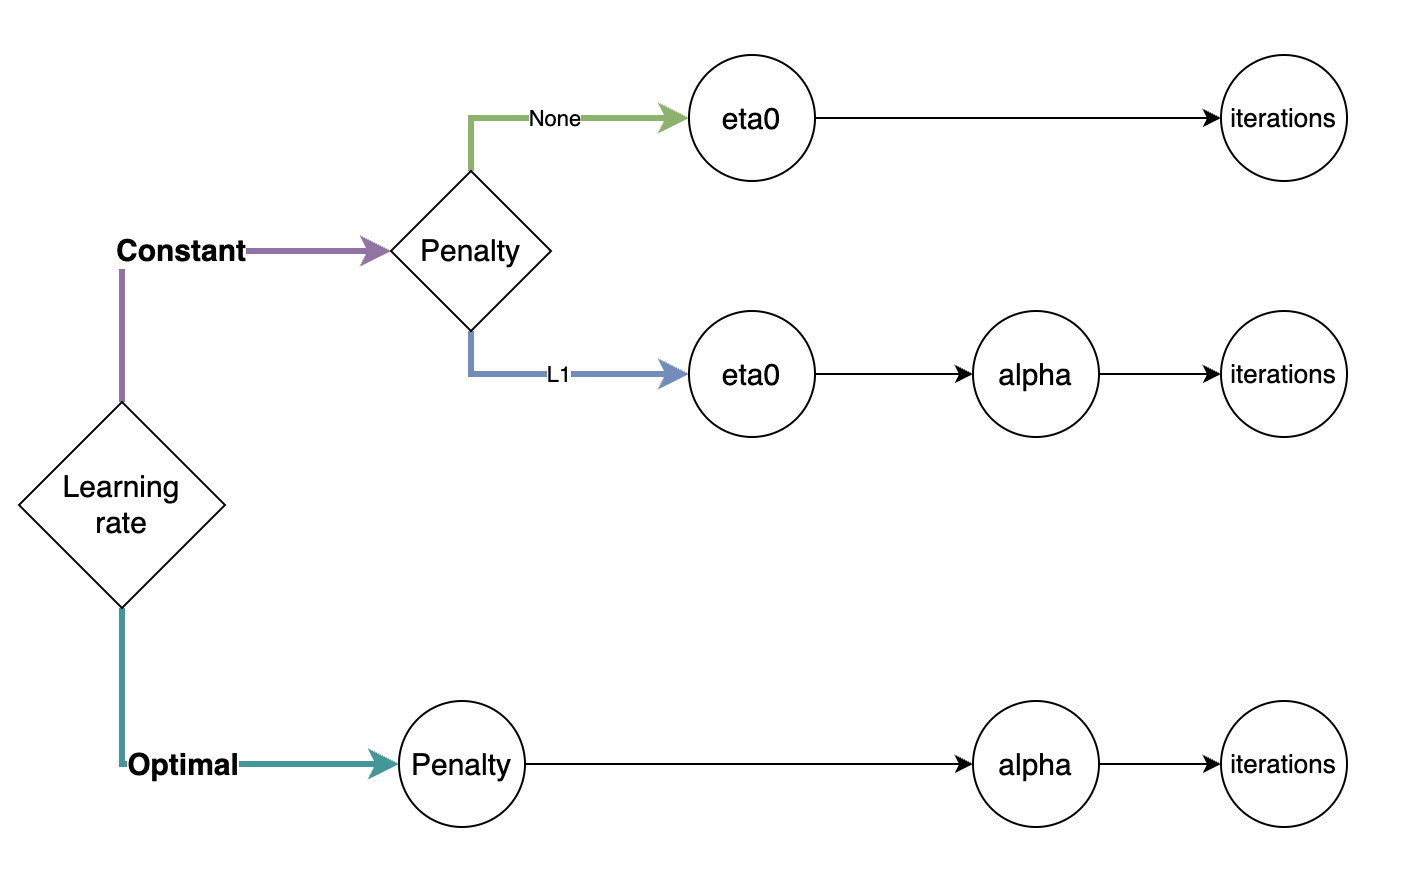

In [45]:
import warnings
warnings.filterwarnings('ignore')

## Train Model
def logTrain(args): # penalty, max_iter, learning_rate, alpha, eta0
  log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, **args)
  log_classifier.fit(X_train_OH, Y_train_OH)
  # Generate prediction
  prediction = log_classifier.predict(X_test_OH)
  # Calculate accuracy
  accuracy = accuracy_score(Y_test_OH,prediction)
  return accuracy

# Table structure
# learning_rate penalty eta alpha max_iterations accuracy 
results = []

for learning_rate in learning_rates:
  for penalty in penalties:
    if learning_rate == 'optimal': # Skip eta0
      for alpha in alphas:
        for iteration in iterations:
          print('=> learning_rate [{rate}] Penalty [{penalty}] eta0 [XX] alpha [{alpha}]  max_iterations [{iteration}]'.format(rate=learning_rate, penalty=penalty, alpha=alpha, iteration=iteration),end='')

          accuracy = logTrain({'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration, 'alpha':alpha })
          
          results.append([learning_rate, penalty, 'XX', alpha, iteration, accuracy])
          print('    ==> Accuracy: {acc} '.format(acc=accuracy))
           
    else:
      if penalty is None:
        for eta in etas:
          for iteration in iterations:
            print('=> learning_rate [{rate}] Penalty [{penalty}] eta0 [{eta}] alpha [XX]  max_iterations [{iteration}]'.format(rate=learning_rate, penalty=penalty, eta=eta, iteration=iteration),end='')

            accuracy = logTrain({'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration, 'eta0':eta })

            results.append([learning_rate, penalty, eta, 'XX', iteration, accuracy])
            print('    ==> Accuracy: {acc} '.format(acc=accuracy))
            
      else:
        for eta in etas:
          for alpha in alphas:
            for iteration in iterations:
              print('=> learning_rate [{rate}] Penalty [{penalty}] eta0 [{eta}] alpha [{alpha}]  max_iterations [{iteration}]'.format(rate=learning_rate, penalty=penalty, eta=eta, alpha=alpha, iteration=iteration),end='')

              accuracy = logTrain({'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration, 'eta0':eta, 'alpha':alpha })

              results.append([learning_rate, penalty, eta, alpha, iteration, accuracy])
              print('    ==> Accuracy: {acc} '.format(acc=accuracy))
              

print("Numero de entrenamientos: {total}".format(total=len(results)))


=> learning_rate [constant] Penalty [None] eta0 [0.001] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.8586956521739131 
=> learning_rate [constant] Penalty [None] eta0 [0.001] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.8586956521739131 
=> learning_rate [constant] Penalty [None] eta0 [0.01] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.8586956521739131 
=> learning_rate [constant] Penalty [None] eta0 [0.01] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.8478260869565217 
=> learning_rate [constant] Penalty [None] eta0 [0.1] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.8260869565217391 
=> learning_rate [constant] Penalty [None] eta0 [0.1] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.8478260869565217 
=> learning_rate [constant] Penalty [None] eta0 [1] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.5108695652173914 
=> learning_rate [constant] Penalty [None] eta0 [1] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.8260869565217391 
=> learnin

**Manejando los resultados de los modelos entrenados**

Establecer un umbral de precisión del 0,75

In [46]:
results_df = pd.DataFrame(results,columns=['learning rate','penalty','eta0','alpha','max iterations','accuracy'])
threshold = 0.75
results_top = results_df[results_df['accuracy'] > threshold].sort_values(by='accuracy',ascending=False)
results_top.head(10)

,learning rate,penalty,eta0,alpha,max iterations,accuracy
53,constant,l1,1,0.00001,100,0.880435
98,optimal,l1,XX,0.001,10,0.880435
67,constant,l1,10,0.00001,100,0.869565
29,constant,l1,0.01,0.001,100,0.869565
28,constant,l1,0.01,0.001,10,0.869565
71,constant,l1,10,0.001,100,0.869565
84,optimal,None,XX,0.001,10,0.869565
0,constant,None,0.001,XX,10,0.858696
44,constant,l1,0.1,0.01,10,0.858696
1,constant,None,0.001,XX,100,0.858696


In [47]:
learning_rate, penalty, eta, alpha, iteration, accuracy = results_top.iloc[0]

params = {'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration}

if eta is not 'XX':
  params['eta0']=eta

if alpha is not 'XX':
  params['alpha']=alpha

params

{'learning_rate': 'constant',
 'penalty': 'l1',
 'max_iter': 100,
 'eta0': 1,
 'alpha': 1e-05}

### **ANÁLISIS CON EL MEJOR DE LOS CASOS**

Precisión (Acurracy) :  80.43%
Puntuación de validación cruzada(Cross Validation Score) con Train :  83.26%
Puntuación de validación cruzada(Cross Validation Score) con Val :  88.37%
Puntuación ROC_AUC :  80.40%


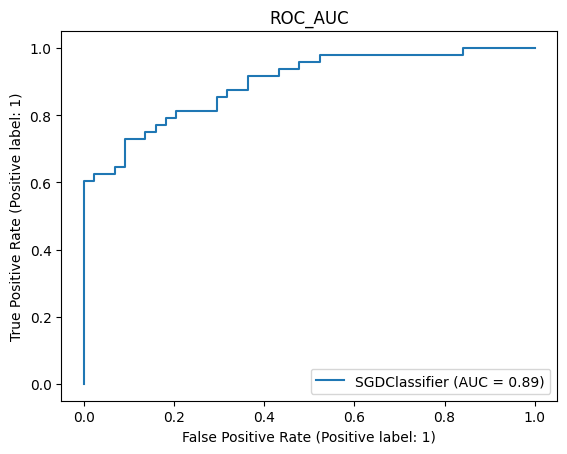

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import RocCurveDisplay

log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, **params)
log_classifier.fit(X_train_OH, Y_train_OH)
# Generate prediction
prediction = log_classifier.predict(X_test_OH)
# Calculate accuracy
accuracy = accuracy_score(Y_test_OH,prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(Y_test_OH,prediction)))
print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train_OH,Y_train_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH,Y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(Y_test_OH,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test_OH,Y_test_OH)
plt.title('ROC_AUC')
plt.show()


              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.81      0.81      0.81        48

    accuracy                           0.80        92
   macro avg       0.80      0.80      0.80        92
weighted avg       0.80      0.80      0.80        92



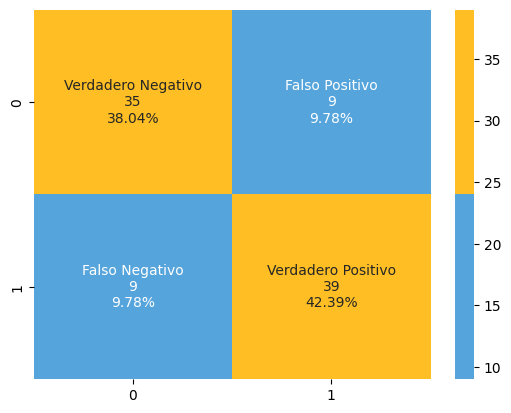

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(Y_test_OH,log_classifier.predict(X_test_OH))
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(Y_test_OH,log_classifier.predict(X_test_OH)))